## Analyze effect of amino acid and codon mutations on mRNA stability of FK

In [2]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(plotrix))

### Global themes

In [3]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [4]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

### Load sample annotations and counts

In [5]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment='#')

Rows: 8 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (6): insert_read, insert_start, insert_length, umi_read, umi_start, umi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
spikein_annotations <- read_csv("../annotations/insert_annotations.csv", show_col_types = F) %>%
    filter(is.na(codon)) %>%
    select(insert_num, insert_seq, wt_motif, motif, mutstart, codon) %>%
    mutate(aa = 'spikein', motif = 'SPIKEIN')

In [7]:
variant_annotations <- read_csv("../annotations/insert_annotations.csv", show_col_types = F) %>%
    drop_na() %>%
    mutate(wt_seq = 'TTCAAGTTTAAGTTCAAGTTCAAATTCAAGTTTAAGTTCAAGTTCAAA') %>%
    mutate(aa = as.character(translate(DNAStringSet(codon), no.init.codon = T))) %>%
    mutate(aa_loc = (mutstart+2)/3) %>%
    mutate(wt_codon = substr(wt_seq, mutstart, mutstart+2)) %>%
    mutate(wt_aa = as.character(translate(DNAStringSet(wt_codon), no.init.codon = T))) %>% 
    group_by(insert_seq) %>%
    slice(1) %>% # removes repeated WT sequences
    ungroup() %>%
    select(insert_num, insert_seq, wt_motif, motif, mutstart, codon, aa, aa_loc, wt_codon, wt_aa) %>%
    bind_rows(spikein_annotations)

### Read in raw variant counts

In [8]:
raw_counts <- list.files("../data/annotated_insert_umi_counts", full.names = T, pattern = "csv$") %>%
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(sample_name, -file, data) %>%
  unnest(data)

In [9]:
head(raw_counts)

sample_name,insert_num,umi,count
<chr>,<dbl>,<chr>,<dbl>
hel2_fk8_dms_grna_rep2,1025,GGGGGGG,1420
hel2_fk8_dms_grna_rep2,1026,GGGGGGG,895
hel2_fk8_dms_grna_rep2,79,GGGGGGG,222
hel2_fk8_dms_grna_rep2,268,GGGGGGG,192
hel2_fk8_dms_grna_rep2,1003,GGGGGGG,189
hel2_fk8_dms_grna_rep2,395,GGGGGGG,150


### Join raw counts with variant annotations

In [10]:
variant_counts <- raw_counts %>%
    mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
    inner_join(variant_annotations, by = c("insert_num"))

In [11]:
seq_effect <- variant_counts %>%
    group_by(sample_name, insert_num) %>%
    summarize(read_count = sum(count), umi_count = n(), .groups='drop') %>%
    left_join(select(sample_annotations, sample_id, sample_name), by=c('sample_name')) %>%
    mutate(sample_type = str_extract(sample_name, "rna|grna"), 
            replicate = str_extract(sample_name, "1$|2$")) %>%
    mutate(replicate = ifelse(is.na(replicate), '1', replicate)) %>%
    mutate(genotype = str_extract(sample_name, "[^_]+"))

### Calculate average LFC between replicates

In [12]:
umi_count_lfc <- seq_effect %>%
  select(-sample_id, -sample_name, -read_count) %>%
  pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
  filter(!is.na(grna_1), !is.na(grna_2), !is.na(rna_1), !is.na(rna_2)) %>% 
  mutate(lfc_1 = log2(rna_1/grna_1), lfc_2 = log2(rna_2/grna_2))

In [13]:
sc_umi_lfc <- seq_effect %>%
  select(-sample_id, -sample_name, -read_count) %>%
  left_join(variant_annotations, by='insert_num') %>%
  filter(motif == 'SPIKEIN') %>%
  group_by(genotype, motif, replicate, sample_type) %>%
  summarize(umi_count = sum(umi_count)) %>%
  pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
  mutate(lfc_1 = log2(rna_1/grna_1), lfc_2 = log2(rna_2/grna_2)) %>%
  mutate(lfc = mean(c(lfc_1,lfc_2)), lfc_diff = abs(lfc_1 - lfc_2))

`summarise()` has grouped output by 'genotype', 'motif', 'replicate'. You can
override using the `.groups` argument.


In [14]:
lfc_umi <- umi_count_lfc %>%
    left_join(variant_annotations, by='insert_num') %>%
    filter(motif != 'SPIKEIN') %>%
    group_by(genotype, insert_num) %>%
    mutate(lfc_1 = log2(rna_1/grna_1), lfc_2 = log2(rna_2/grna_2)) %>%
    mutate(lfc = mean(c(lfc_1,lfc_2)), lfc_diff = abs(lfc_1 - lfc_2)) %>%
    mutate(wt = (aa == wt_aa)) %>%
    ungroup() %>%
    bind_rows(sc_umi_lfc)

In [15]:
lfc_umi_sc <- lfc_umi %>%
    select(insert_num, genotype, insert_seq, motif, mutstart, codon, aa, aa_loc, wt_codon, wt_aa, wt, lfc) %>%
    group_by(genotype) %>%
    mutate(lfc_sc = lfc - lfc[motif == 'SPIKEIN']) %>%
    ungroup()

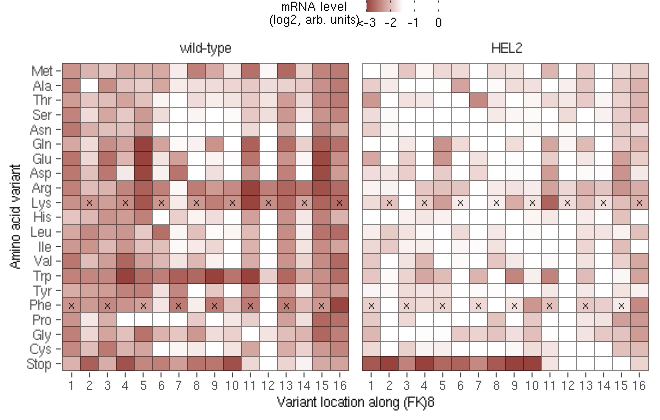

In [40]:
options(repr.plot.width = 5.5, repr.plot.height = 3.5)

AMINO_ACID_CODE["*"] = "Stop"
aa_reorder_list <- c("Met", "Ala", "Thr", "Ser", "Asn", "Gln", "Glu", "Asp", "Arg", "Lys", "His", "Leu", "Ile", "Val", "Trp", "Tyr", "Phe", "Pro", "Gly", "Cys", "Stop")

plot_data <- lfc_umi_sc %>%
  mutate(lfc_m = lfc_sc - max(lfc_sc)) %>%
  mutate(genotype = ifelse(genotype == 'wt', 'wild-type', ' HEL2')) %>%
  mutate(genotype = factor(genotype, levels=c('wild-type', ' HEL2'))) %>%
  mutate(scaled_lfc = ifelse(lfc_m >= -3 & lfc_m <= 2, lfc_m, ifelse(lfc_m > 2, 2, ifelse(lfc_m < -3, -3, NA)))) %>%
  mutate(aa = AMINO_ACID_CODE[aa])

wt_plot_data <- plot_data %>% 
  filter(wt)

plot_data %>%
  drop_na() %>%
  mutate(scaled_lfc = ifelse(lfc_m >= -3 & lfc_m <= 2, lfc_m, ifelse(lfc_m > 2, 2, ifelse(lfc_m < -3, -3, NA)))) %>%
  ggplot(aes(x = as.character(aa_loc), y = aa, fill = scaled_lfc)) + 
  geom_tile(color = "black") +
  geom_text(label = "x", color = "black", data = wt_plot_data, size = 2) +
  facet_wrap(~genotype) +
  scale_y_discrete(limits = rev(aa_reorder_list)) +
  scale_x_discrete(limits = as.character(seq(1,16,1))) +
  scale_fill_gradient2(
                        low = "#97423d",
                        high = 'white',
                        midpoint = -1.5,
                        guide = guide_colorbar(barwidth = 3, barheight = 0.5, ticks.colour = "black", title.hjust = 0.5), 
                        na.value = "grey50",
                        labels = rev(c('0', '-1', '-2', '<-3'))) +
  theme +
  theme(axis.line.y = element_blank(),
        axis.line.x = element_blank(),
        legend.text = element_text(size=7),
        legend.title = element_text(size=7),
        strip.text.x = element_text(size=8),
        axis.text.x = element_text(size=7),
        legend.box.margin=margin(-12,-15,-15,-18),
        legend.position='top',
        legend.justification='center'
        ) +
  labs(x = "Variant location along (FK)8", y = "Amino acid variant", fill = 'mRNA level\n(log2, arb. units)')

ggsave("../figures/umi_count_spikein_norm_lfc.pdf", width=5.1, height=3.5)

## Plot distributions at each location

In [17]:
stop_inserts <- variant_annotations %>%
    filter(aa == '*') %>%
    dplyr::pull(insert_num)

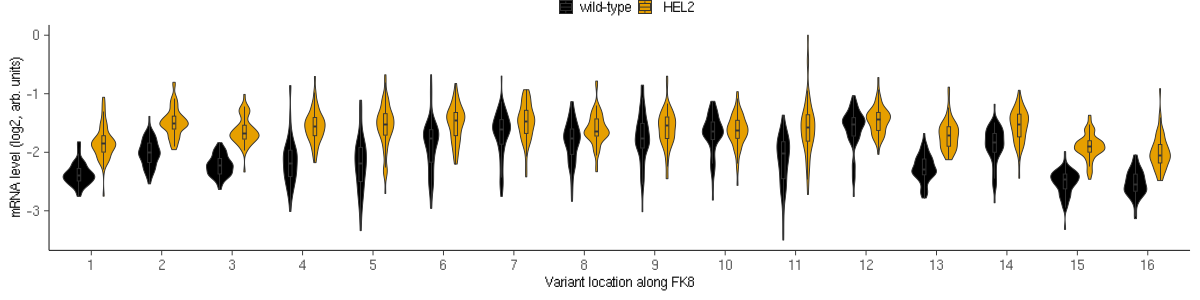

In [18]:
options(repr.plot.width = 10, repr.plot.height = 2.5)

lfc_umi_sc %>%
    filter(!(insert_num %in% stop_inserts)) %>%
    mutate(lfc_m = lfc_sc - max(lfc_sc)) %>%
    mutate(genotype = ifelse(genotype == 'wt', 'wild-type', ' HEL2')) %>%
    mutate(genotype = factor(genotype, levels=c('wild-type', ' HEL2'))) %>%
    drop_na() %>%
    ggplot() +
    aes(x=as.factor(aa_loc), y=lfc_m, fill=genotype) +
    geom_violin(linewidth=0.2, position=position_dodge(width=0.7)) +
    geom_boxplot(linewidth=0.2, width=0.1, position=position_dodge(width=0.7), outlier.shape=NA) +
    scale_fill_manual(values=c('wild-type'='black', ' HEL2'='#E69F00')) +
    theme + 
    theme(legend.box.margin=margin(-12,-12,-12,-12),
        legend.key.width=unit(3, 'mm'),
        legend.key.height=unit(3, 'mm'),
        legend.position='top', 
        legend.justification='center'
    ) + 
    labs(x = "Variant location along (FK)8", y = 'mRNA level (log2, arb. units)', fill='')

ggsave("../figures/dist_scnorm_by_position.pdf", width=4.8, height=1.8)

### Calculate significance of distributions

In [19]:
wilcox_data <- lfc_umi_sc %>%
    filter(!(insert_num %in% stop_inserts)) %>%
    mutate(lfc_m = lfc_sc - max(lfc_sc)) %>%
    drop_na() %>%
    select(insert_num, lfc_m, aa_loc, genotype) %>%
    pivot_wider(names_from=c(genotype), values_from=lfc_m) %>%
    drop_na()

In [20]:
w_results <- tibble(pos=0, p=0)
for (loc in seq(1,16,1)) {
    w <- wilcox_data %>%
        filter(aa_loc == loc) 
    wtest <- wilcox.test(w$hel2, w$wt, alternative = "greater")
    w_results <- w_results %>%
        add_row(pos=loc, p=wtest$p.value)
}
w_results <- w_results %>% dplyr::slice(-1)

In [21]:
w_results %>%
    print()

# A tibble: 16 × 2
     pos        p
   <dbl>    <dbl>
 1     1 9.47e-18
 2     2 1.70e-17
 3     3 3.59e-20
 4     4 5.44e-15
 5     5 2.28e-11
 6     6 2.88e- 7
 7     7 2.98e- 3
 8     8 3.32e- 4
 9     9 1.35e- 2
10    10 2.93e- 1
11    11 2.90e-10
12    12 1.31e- 2
13    13 1.67e-18
14    14 1.23e- 8
15    15 1.04e-19
16    16 2.54e-17


## Plot replicate agreement

In [22]:
label_data <- umi_count_lfc %>%
  mutate(genotype = ifelse(genotype == 'wt', 'wild-type', ' HEL2')) %>%
  mutate(genotype = factor(genotype, levels=c('wild-type', ' HEL2'))) %>%
  group_by(genotype) %>%
  nest() %>%
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~lfc_1 + lfc_2, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r = ", round(estimate, 2))) %>%
  mutate(p2 = as.numeric(str_extract(p.value, '(?<=e).+')) + 1) %>%
  mutate(pval = paste0('p < 1e', p2))

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


In [23]:
label_data

genotype,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative,p2,pval
<fct>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
HEL2,1009,r = 0.62,25.31849,7.738176e-110,1007,0.5844512,0.6599841,Pearson's product-moment correlation,two.sided,-109,p < 1e-109
wild-type,1010,r = 0.87,55.24030,3.438844e-307,1008,0.8508199,0.8815416,Pearson's product-moment correlation,two.sided,-306,p < 1e-306


`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


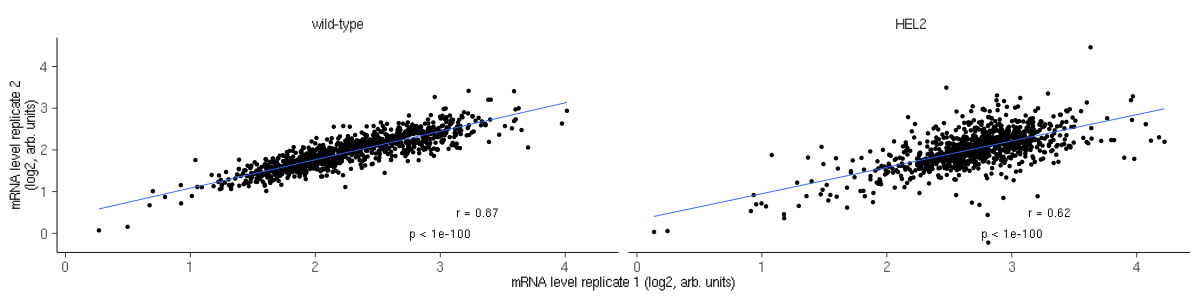

In [24]:
umi_count_lfc %>% 
  mutate(genotype = ifelse(genotype == 'wt', 'wild-type', ' HEL2')) %>%
  mutate(genotype = factor(genotype, levels=c('wild-type', ' HEL2'))) %>%
  ggplot(aes(x = lfc_1, y = lfc_2)) +
  facet_wrap(~genotype, ncol = 2) +
  geom_point(size = 0.2) +
  geom_text(aes(label = estimate), x = 3.3, y = 0.5, data = label_data, size=6.5/.pt) +
  geom_text(aes(label = 'p < 1e-100'), x = 3.0, y = 0, data = label_data, size=6.5/.pt) +
  geom_smooth(method=lm, linewidth=0.2, se=FALSE) +
  theme + 
  theme(strip.background = element_blank(),
        strip.text.x = element_text(size = 8)) + 
  labs(x = "mRNA level replicate 1 (log2, arb. units)", y = "mRNA level replicate 2\n(log2, arb. units)")

ggsave("../figures/replicate_lfc_scatter.pdf", width=2.5, height=1.5)